In [85]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split

In [86]:
class SBS():
    def __init__(self, classifier, k_features, test_size=.25, random_state=1):
        self.classifier = classifier
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test =  train_test_split (
            X, y, test_size=self.test_size, 
            stratify=y, random_state=self.random_state
        )
        
        dim = X_train.shape[1]
        self.indices = tuple(range(dim))
        self.subsets = [self.indices]
        score = self.get_score(X_train, X_test, y_train, y_test, self.indices)
        
        self.scores = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices, r=dim-1):
                score = self.get_score(
                    X_train, X_test, y_train, y_test, p)
                scores.append(score)
                subsets.append(p)

            best_acc_index = np.argmax(scores)
            self.indices = subsets[best_acc_index]
            self.subsets.append(self.indices)
            dim -= 1

            self.scores.append(scores[best_acc_index])
        
        self.k_score = self.scores[-1]
        return self


    def transform(self, X):
        return X[:, self.indices]

    def get_indices(self):
        return self.indices

    def get_score(self, X_train, X_test, y_train, y_test, col_indices):
        self.classifier.fit(X_train[:, col_indices], y_train)
        current_score = self.classifier.score(
            X_test[:, col_indices], y_test)
        return current_score

In [87]:
df = pd.read_csv('./datasets/diabetes.csv')
df.head(5)

,col1,col2,col3,col4,col5,col6,col7,col8,y
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [88]:
X = df.drop(columns=['y']).values
y = df['y'].values

In [89]:
X.shape

(768, 8)

In [90]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
sbs = SBS(log_reg, 1)
sbs.fit(X, y)
X_transformed = sbs.transform(X)

c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [91]:
df.iloc[:, list(sbs.get_indices())]

,col2
0,148
1,85
2,183
3,89
4,137
...,...
763,101
764,122
765,121
766,126


In [92]:
sbs.k_score

0.7239583333333334

In [93]:
k_lens = [len(k_len) for k_len in sbs.subsets]

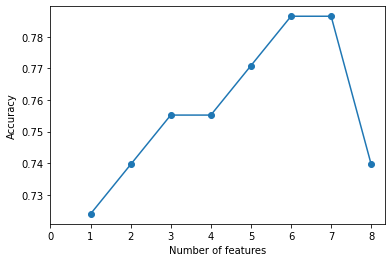

In [94]:
import matplotlib.pyplot as plt 
plt.plot(k_lens, sbs.scores, marker='o')
plt.xticks(list(range(df.shape[1])))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# We can achieve best accuracy in just 6 features